In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from warnings import filterwarnings
pd.set_option('display.float_format', lambda num: '%1.3f'%num)
pd.set_option('display.max_columns', 99)
filterwarnings('ignore')

import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   uid                         10000 non-null  int64  
 1   city                        10000 non-null  object 
 2   description                 9999 non-null   object 
 3   homeType                    10000 non-null  object 
 4   latitude                    10000 non-null  float64
 5   longitude                   10000 non-null  float64
 6   garageSpaces                10000 non-null  int64  
 7   hasSpa                      10000 non-null  bool   
 8   yearBuilt                   10000 non-null  int64  
 9   numOfPatioAndPorchFeatures  10000 non-null  int64  
 10  lotSizeSqFt                 10000 non-null  float64
 11  avgSchoolRating             10000 non-null  float64
 12  MedianStudentsPerTeacher    10000 non-null  int64  
 13  numOfBathrooms              1000

<Axes: >

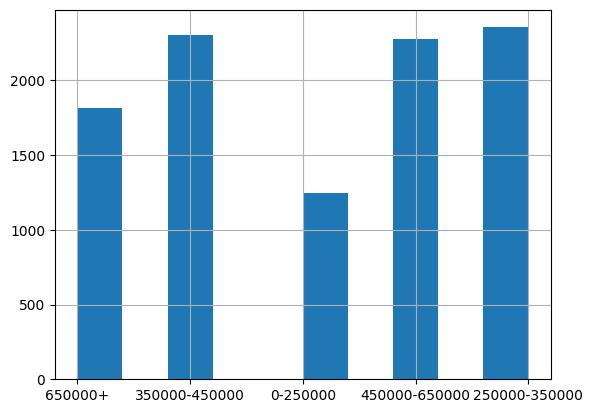

In [3]:
data['priceRange'].hist()

In [5]:
def split_num_cat_features(df, target=None):
    num_features = [col for col in df if df[col].dtype=='float64' or df[col].dtype=='int64' and col != target]
    cat_features = [col for col in df.columns if col not in num_features and col != target]

    return target, num_features, cat_features

target, num_features, cat_features = split_num_cat_features(data, 'priceRange')

print(target)
print(num_features)
print(cat_features)

priceRange
['uid', 'latitude', 'longitude', 'garageSpaces', 'yearBuilt', 'numOfPatioAndPorchFeatures', 'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher', 'numOfBathrooms', 'numOfBedrooms']
['city', 'description', 'homeType', 'hasSpa']


In [8]:
def check_missing_zeros(df):
    missing_zeros_df = pd.DataFrame({
        'percent_missing': round(df.isna().sum() * 100 / len(df), 2),
        'percent_zeros': round(df.isin([0]).sum() * 100 / len(df), 2)
    }).sort_values(['percent_missing', 'percent_zeros'], ascending=False)

    return missing_zeros_df

def check_corr(df):
    corrMatrix = df.corr()
    f, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(corrMatrix, annot=True, cmap='YlGnBu')
    plt.show()

def plot_dist(df, c, i, bins=10):
    plt.figure(i)
    sns.distplot(df[c], bins=bins)
    plt.title(f'Distribution of {c.upper()}')

def card_check(df, cat_features):
    card_df = pd.DataFrame(
        df[cat_features].apply(pd.Series.nunique).sort_values(ascending=False), columns=['Cardinality']
    )
    return card_df

In [9]:
missing_zeros_df = check_missing_zeros(data)
missing_zeros_df

,percent_missing,percent_zeros
description,0.010,0.000
hasSpa,0.000,91.750
numOfPatioAndPorchFeatures,0.000,60.720
garageSpaces,0.000,44.580
uid,0.000,0.000
city,0.000,0.000
homeType,0.000,0.000
latitude,0.000,0.000
longitude,0.000,0.000
yearBuilt,0.000,0.000


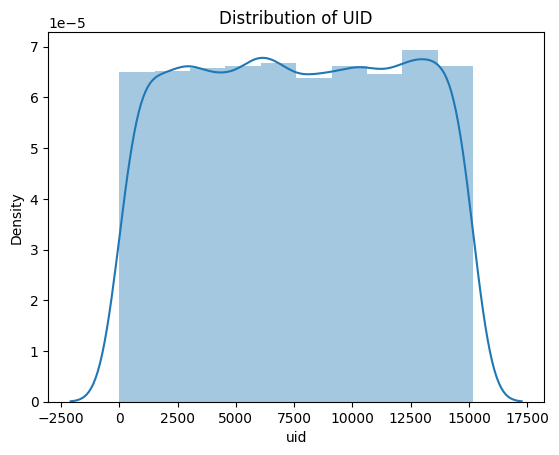

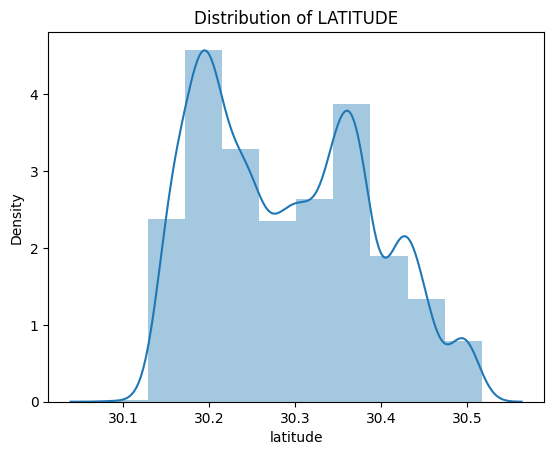

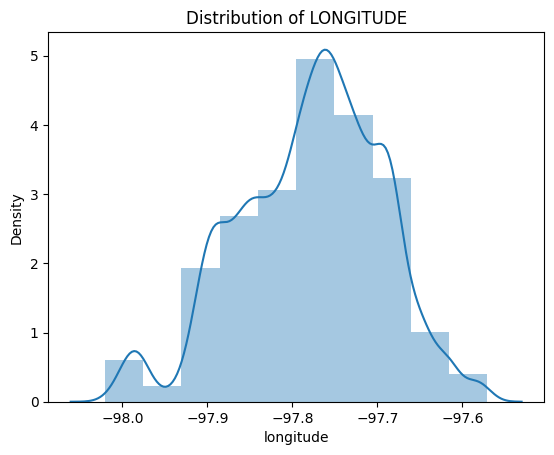

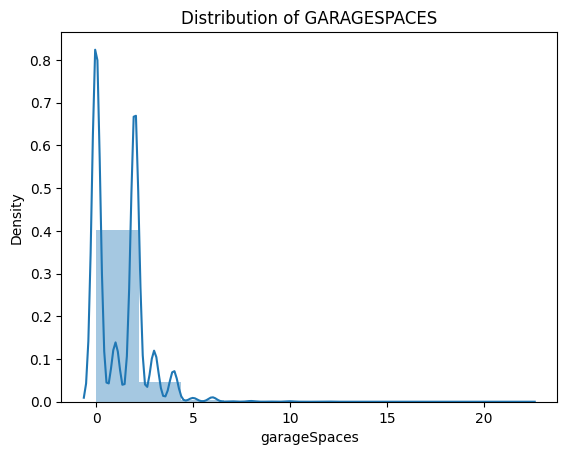

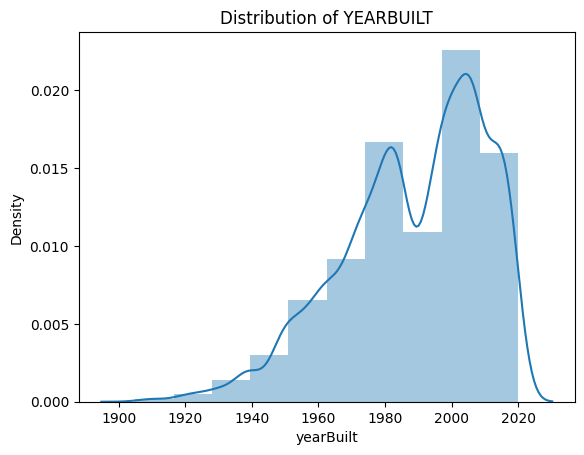

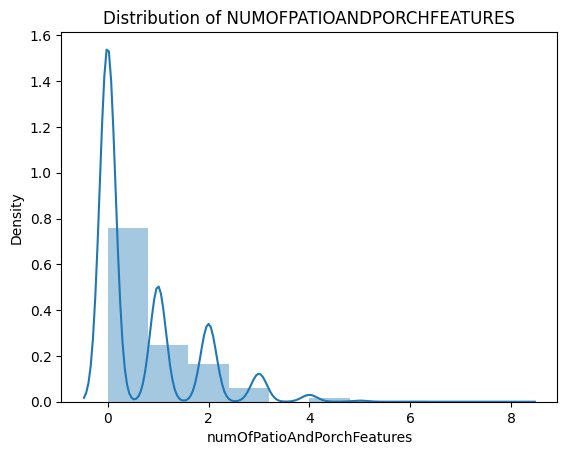

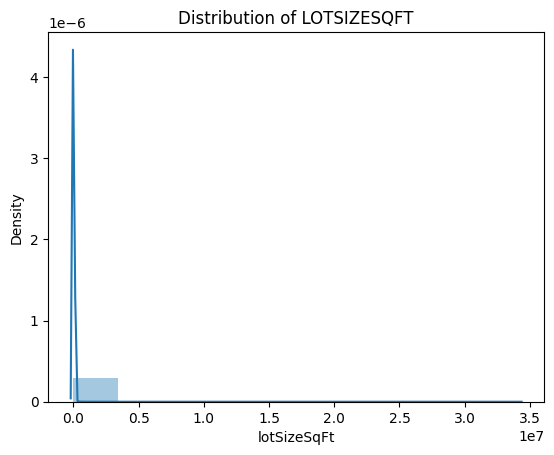

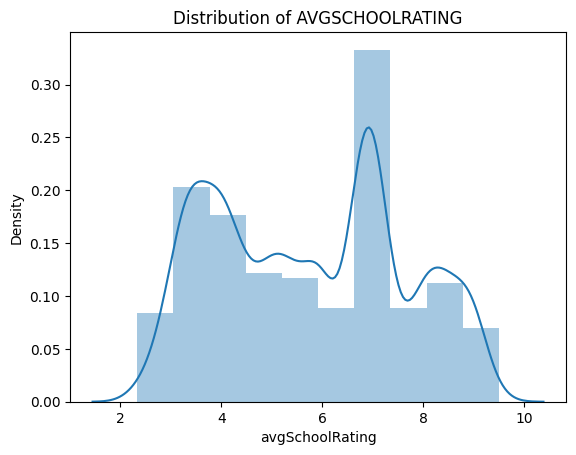

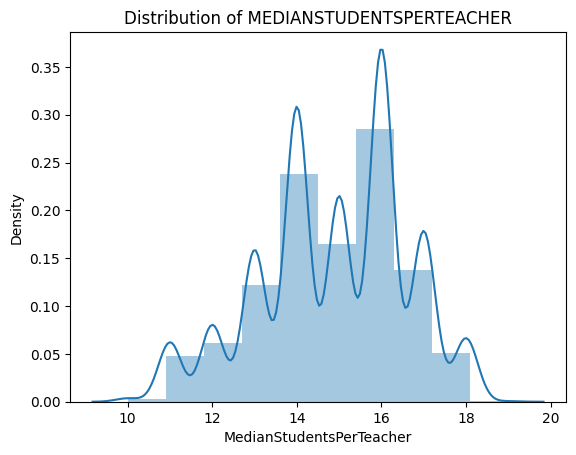

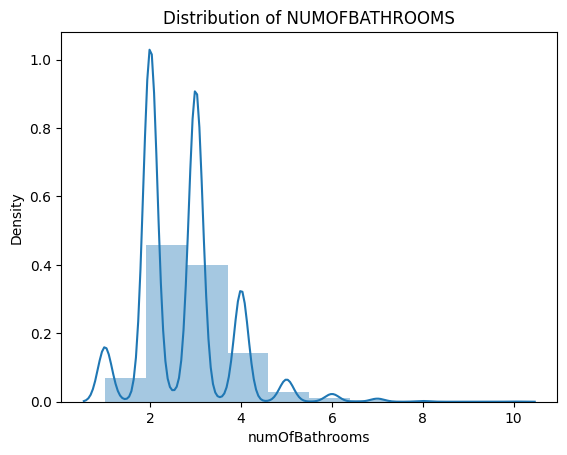

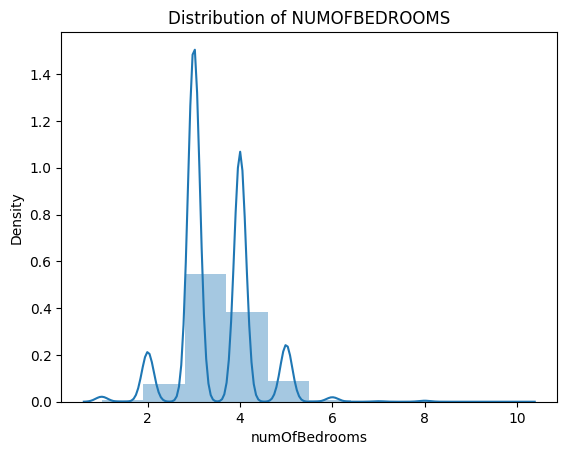

In [11]:
for i, n in enumerate(num_features):
    plot_dist(data, n, i)

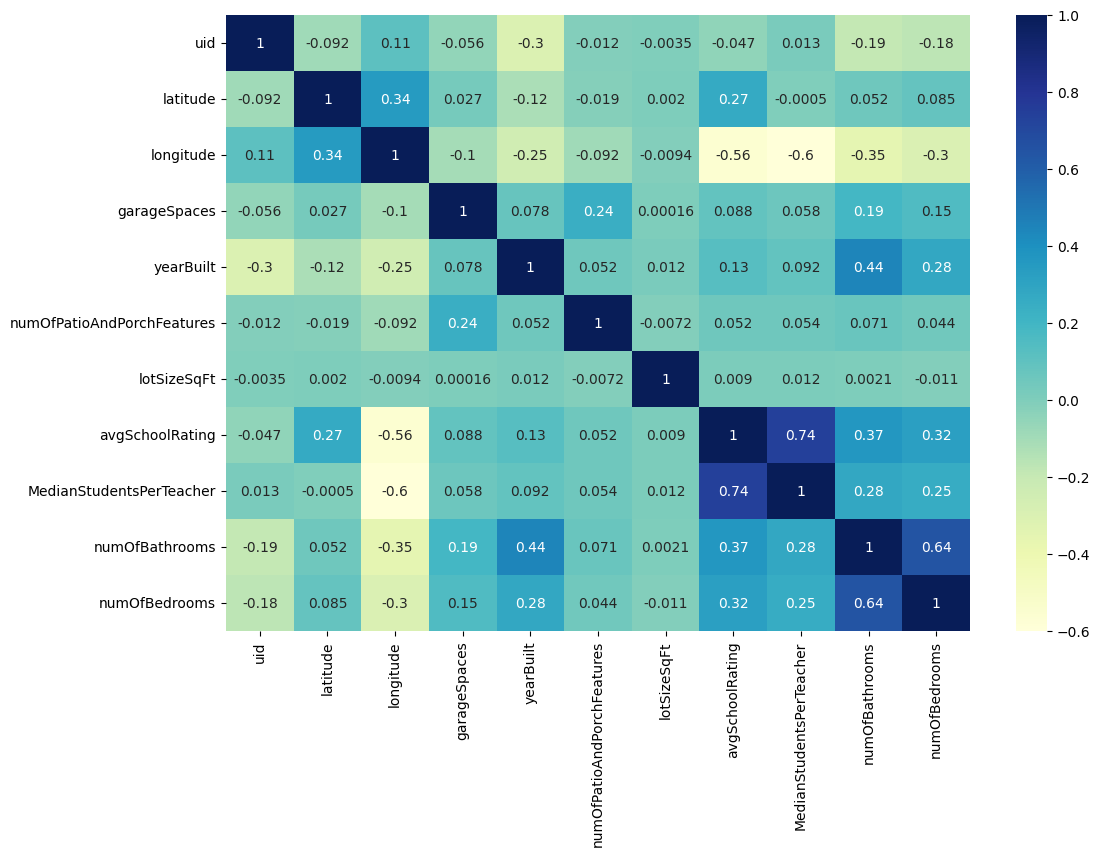

In [12]:
check_corr(data[num_features])

In [13]:
ignore_cols = []

for c in ['description', 'uid', 'hasSpa', 'MedianStudentsPerTeacher']:
    ignore_cols.append(c)

selected_cols = [col for col in cat_features + num_features + [target] if col not in ignore_cols]
data_selected = data[selected_cols]
data_selected.head()

,city,homeType,latitude,longitude,garageSpaces,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,numOfBathrooms,numOfBedrooms,priceRange
0,austin,Single Family,30.380,-97.801,0,1988,0,102366.000,7.000,4.000,4,650000+
1,austin,Single Family,30.199,-97.860,0,1997,0,6534.000,6.667,3.000,4,350000-450000
2,austin,Single Family,30.227,-97.696,0,1952,0,5619.000,3.333,1.000,2,0-250000
3,austin,Single Family,30.205,-97.792,4,1976,0,6416.000,4.000,2.000,4,0-250000
4,austin,Single Family,30.345,-97.767,2,1984,0,10759.000,7.000,3.000,5,650000+


In [14]:
data_selected.city.value_counts(normalize=True)

city
austin             0.990
del valle          0.006
pflugerville       0.003
driftwood          0.001
manchaca           0.000
dripping springs   0.000
west lake hills    0.000
Name: proportion, dtype: float64

In [15]:
data_selected.homeType.value_counts(normalize=True)

homeType
Single Family           0.943
Condo                   0.033
Townhouse               0.011
Multiple Occupancy      0.006
Residential             0.003
Apartment               0.002
Mobile / Manufactured   0.001
MultiFamily             0.001
Vacant Land             0.000
Other                   0.000
Name: proportion, dtype: float64

In [16]:
data_selected = data_selected[
    (data_selected.city=='austin') & (data_selected.homeType=='Single Family')
]

In [17]:
for c in ['city', 'homeType']:
    ignore_cols.append(c)

selected_cols = [col for col in data_selected.columns if col not in ignore_cols]
data_selected = data_selected[selected_cols]
data_selected.head()

,latitude,longitude,garageSpaces,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,numOfBathrooms,numOfBedrooms,priceRange
0,30.380,-97.801,0,1988,0,102366.000,7.000,4.000,4,650000+
1,30.199,-97.860,0,1997,0,6534.000,6.667,3.000,4,350000-450000
2,30.227,-97.696,0,1952,0,5619.000,3.333,1.000,2,0-250000
3,30.205,-97.792,4,1976,0,6416.000,4.000,2.000,4,0-250000
4,30.345,-97.767,2,1984,0,10759.000,7.000,3.000,5,650000+


In [19]:
features = [col for col in data_selected.columns if col != target]
train, test = train_test_split(data_selected, test_size=0.3, random_state=42, stratify=data_selected[target])

X_train, y_train = train[features], train[target]
X_test, y_test   = test[features], test[target]

print(len(train))
print(len(test))

6529
2799


In [20]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test  = encoder.transform(y_test)

np.save('classes.npy', encoder.classes_)

Train Accuracy: 0.7289018226374636
Test Accuracy : 0.6112897463379778


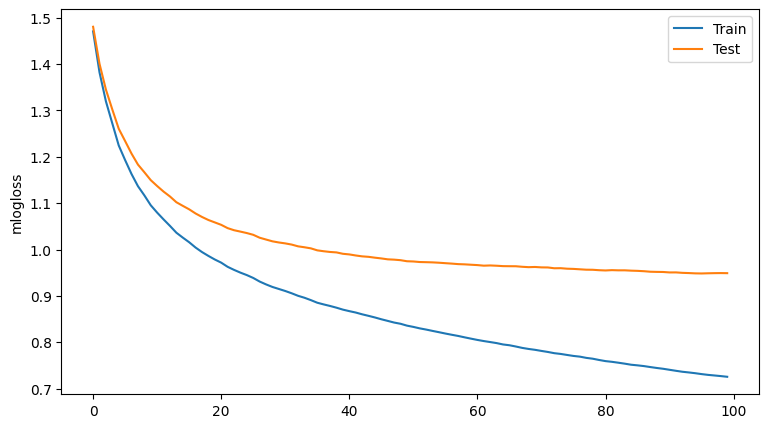

In [23]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax',
                            max_depth=3,
                            num_class=data[target].nunique(),
                            early_stopping_rounds=5,
                            eval_metric=['mlogloss'], seed=42
                            )
xgb_clf.fit(X_train, y_train, verbose=0, eval_set=[(X_train, y_train), (X_test, y_test)])

y_pred_tr = xgb_clf.predict(X_train)
tr_acc    = accuracy_score(y_train, y_pred_tr)
y_pred_t = xgb_clf.predict(X_test)
t_acc    = accuracy_score(y_test, y_pred_t)

print(f'Train Accuracy: {tr_acc}')
print(f'Test Accuracy : {t_acc}')

results = xgb_clf.evals_result()
epochs  = len(results['validation_0']['mlogloss'])
x_axis  = range(0, epochs)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.show()


In [24]:
test_results = pd.DataFrame({'Actual': y_train, 'Predict': y_pred_tr})
test_results.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
Actual,4,4,1,0,4,1,3,4,2,1
Predict,4,4,2,0,4,0,4,4,1,1


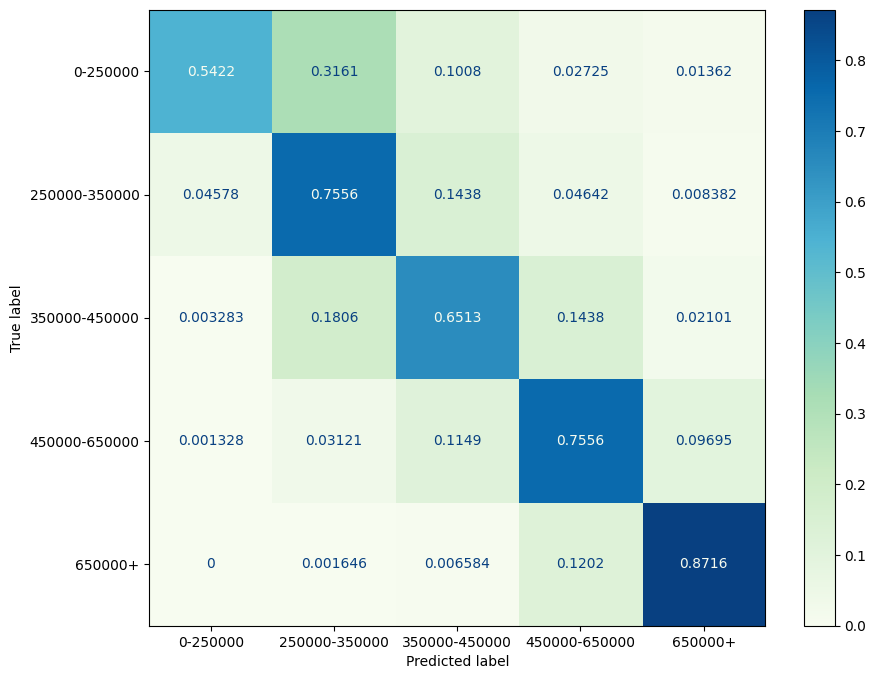

In [27]:
def plot_cm(test_results, normalize='true'):
    cm = confusion_matrix(test_results['Actual'], test_results['Predict'], normalize=normalize)
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
    cm_display.plot(values_format='.4g', cmap='GnBu', ax=ax)

plot_cm(test_results)

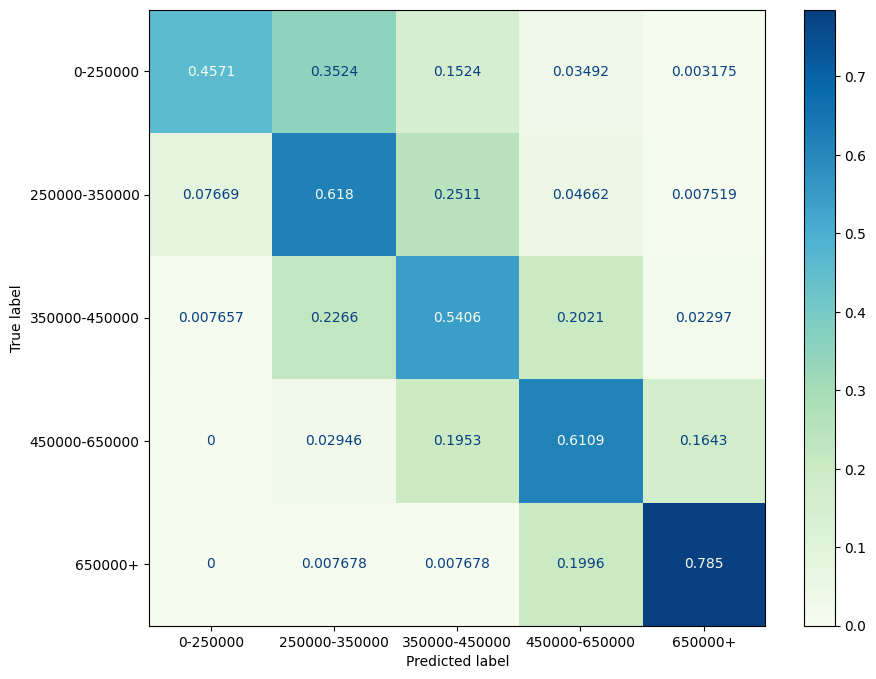

In [28]:
test_results = pd.DataFrame({'Actual': y_test, 'Predict': y_pred_t})
plot_cm(test_results)

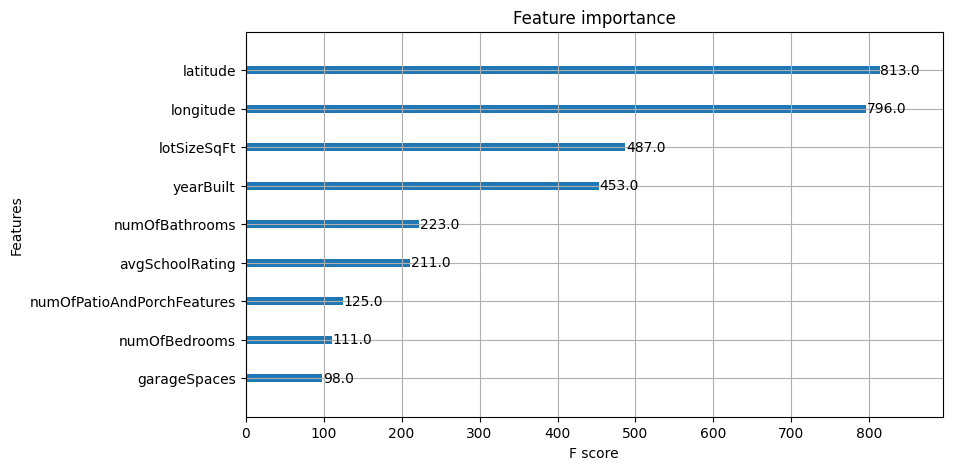

In [29]:
fig, ax = plt.subplots(figsize=(9,5))
plot_importance(xgb_clf, ax=ax)
plt.show()

In [30]:
xgb_clf.save_model('xgb_model.json')

In [38]:
%%writefile app.py
from pydantic import BaseModel
from fastapi import FastAPI
import json
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

app = FastAPI()

xgb_loaded = XGBClassifier()
xgb_loaded.load_model('xgb_model.json')

class model_input(BaseModel):
    latitude                   : float
    longitude                  : float
    garageSpaces               : int
    yearBuilt                  : int
    numOfPatioAndPorchFeatures : int
    lotSizeSqFt                : float
    avgSchoolRating            : float 
    numOfBathrooms             : float
    numOfBedrooms              : int


@app.post('/predict')
def priceRangePred(input_params: model_input):
    input_data = input_params.json()
    input_dict = json.loads(input_data)

    payload = np.array([[
        input_dict['latitude'],
        input_dict['longitude'],
        input_dict['garageSpaces'],
        input_dict['yearBuilt'],
        input_dict['numOfPatioAndPorchFeatures'],
        input_dict['lotSizeSqFt'],
        input_dict['avgSchoolRating'],
        input_dict['numOfBathrooms'],
        input_dict['numOfBedrooms']
    ]])

    pred = xgb_loaded.predict(payload)
    encoder = LabelEncoder()
    encoder.classes_ = np.load('classes.npy', allow_pickle=True)

    return {'prediction': f'I predict the price range to be {encoder.inverse_transform(pred.astype(int))[0]}'}

Overwriting app.py
